In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from matplotlib import pyplot
from tsfresh import extract_features

plt.style.use('seaborn')
import seaborn as sns

from tqdm import tqdm

In [5]:
time_series = pd.read_csv('commit_data_500.csv', header=None, names = ["Date", "Y"])
time_series = time_series.set_index("Date")
time_series.head()

,Y
Date,
2018-12-17 13:00:00,4
2018-12-17 14:00:00,0
2018-12-17 15:00:00,1
2018-12-17 16:00:00,0
2018-12-17 17:00:00,0


In [6]:
import tsfresh
df_shift, y = make_forecasting_frame(time_series["Y"], kind="number", max_timeshift=20, rolling_direction=1)
df_shift.head()

/miniconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)


,time,value,id,kind
15865,2018-12-17 13:00:00,4.0,2018-12-17 14:00:00,number
15021,2018-12-17 13:00:00,4.0,2018-12-17 15:00:00,number
15866,2018-12-17 14:00:00,0.0,2018-12-17 15:00:00,number
14178,2018-12-17 13:00:00,4.0,2018-12-17 16:00:00,number
15022,2018-12-17 14:00:00,0.0,2018-12-17 16:00:00,number


In [7]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False, n_jobs = 5)
X["feature_last_value"] = y.shift(1)
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [8]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2018-12-17 15:00:00,16.0,4.0,-1.000000,-1.000000,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.000000,1.0,0.0
2018-12-17 16:00:00,17.0,5.0,-0.509615,-0.509615,0.000832,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.888889,1.0,1.0
2018-12-17 17:00:00,17.0,6.0,-0.488372,-0.348837,0.356229,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.687500,1.0,0.0
2018-12-17 18:00:00,17.0,6.0,-0.434028,-0.312500,0.261321,1.0,0.0,0.0,0.0,0.0,...,-16.0,0.0,0.0,3.0,1.0,0.0,0.0,2.400000,1.0,0.0
2018-12-17 19:00:00,17.0,6.0,-0.389610,-0.324675,0.227762,1.0,0.0,0.0,0.0,0.0,...,-8.0,0.0,0.0,4.0,1.0,0.0,0.0,2.138889,1.0,0.0


In [14]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 744/744 [01:54<00:00,  3.97it/s]


In [15]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
Date,,
2018-12-17 15:00:00,NaN,1
2018-12-17 16:00:00,NaN,0
2018-12-17 17:00:00,NaN,0
2018-12-17 18:00:00,NaN,0
2018-12-17 19:00:00,NaN,0


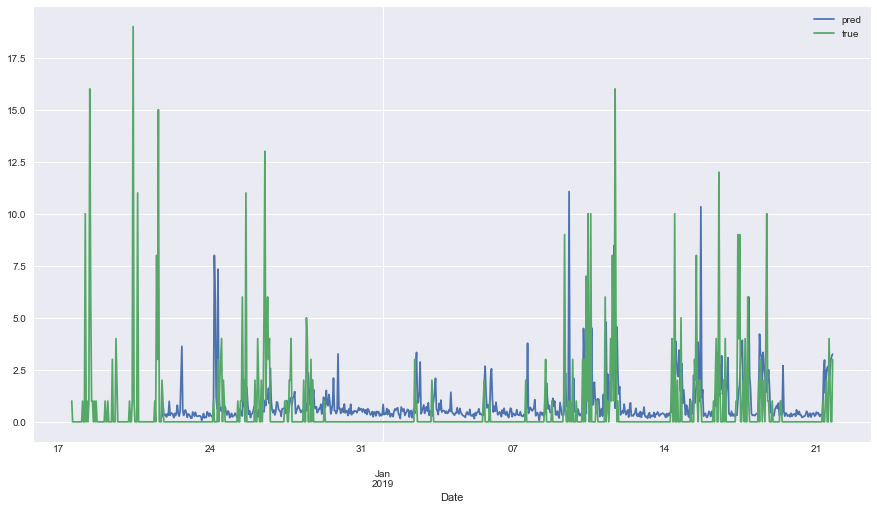

In [17]:
ys.plot(figsize=(15, 8))
#plt.show()
savefig("plot500Ada10.png")

In [18]:
print("MAE ada: \t{}".format(mean_absolute_error(y[isp:], y_pred[isp:])))
print("MSE ada: \t{}".format(mean_squared_error(y[isp:], y_pred[isp:])))
count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if val < 1 and y[idx] < 1:
        truePred += 1

print("Update metric: \t{}%".format(truePred/count*100))

count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if abs(val - y[idx]) <= 1:
        truePred += 1

print("Delta metric: \t{}%".format(truePred/count*100))

MAE ada: 	1.0308997244569185
MSE ada: 	3.491218935299059
Update metric: 	61.61137440758294%
Delta metric: 	67.89099526066352%
